In [1]:


import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel, install_cmdstan
import json
import os
import multiprocessing
import matplotlib.pyplot as plt
import arviz as az
import shutil
install_cmdstan(compiler=True)


c:\Users\stank\anaconda3\envs\pythonProject2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
01:11:52 - cmdstanpy - INFO - Add C++ toolchain to $PATH: C:\Users\stank\.cmdstan\RTools40


CmdStan install directory: C:\Users\stank\.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


True

In [ ]:
install_cmdstan(compiler=True)

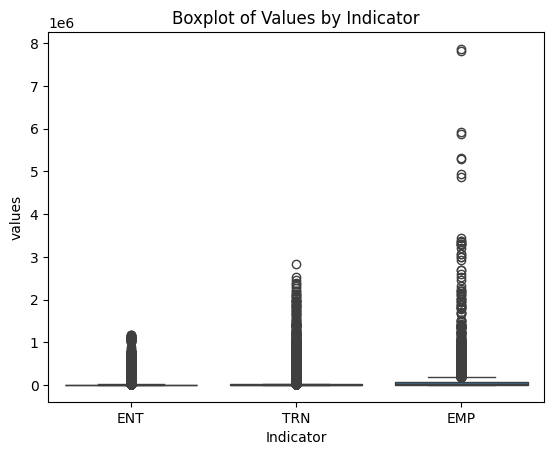

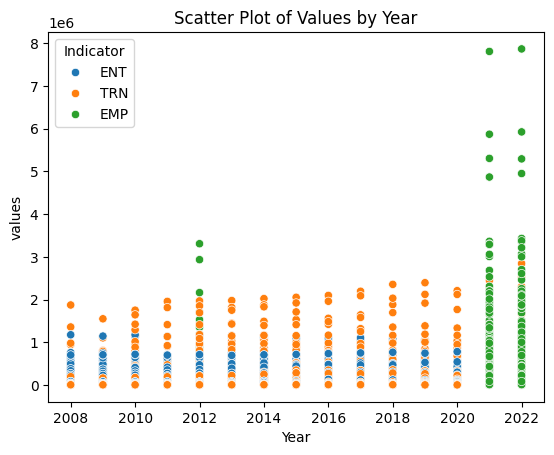

In [2]:
# Load the dataset
data_path = r"df_hierarchical.csv"
df_hierarchical = pd.read_csv(data_path)


df_hierarchical = df_hierarchical[df_hierarchical['Industry'].str.len().isin([1, 2, 3])]

df_hierarchical = df_hierarchical[
    df_hierarchical['CountryCode'].isin(["UK", "FR", "DE", "ES", "IT", "PL", "LT"])
]

df_hierarchical = df_hierarchical[
    df_hierarchical['Indicator'].isin(["TRN", "ENT", "EMP"])
]


df_hierarchical = df_hierarchical.dropna()

df_hierarchical['country'] = pd.factorize(df_hierarchical['CountryCode'])[0] + 1
df_hierarchical['industry'] = pd.factorize(df_hierarchical['Industry'])[0] + 1
df_hierarchical['indicator'] = pd.factorize(df_hierarchical['Indicator'])[0] + 1

df_hierarchical['values'] = df_hierarchical['values'].replace(0, 1e-10)
df_hierarchical['values'] = df_hierarchical['values'].apply(lambda x: x if x > 0 else 1e-10)

import seaborn as sns

# Boxplot for outlier detection
sns.boxplot(data=df_hierarchical, x='Indicator', y='values')
plt.title('Boxplot of Values by Indicator')
plt.show()

# Scatter plot
sns.scatterplot(data=df_hierarchical, x='Year', y='values', hue='Indicator')
plt.title('Scatter Plot of Values by Year')
plt.show()


from scipy.stats import zscore

# Calculate z-scores
df_hierarchical['z_score'] = zscore(df_hierarchical['values'])

# Identify outliers based on z-scores
outliers_z = df_hierarchical[np.abs(df_hierarchical['z_score']) > 3]

# Calculate IQR
Q1 = df_hierarchical['values'].quantile(0.25)
Q3 = df_hierarchical['values'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers based on IQR
outliers_iqr = df_hierarchical[(df_hierarchical['values'] < (Q1 - 1.5 * IQR)) | 
                               (df_hierarchical['values'] > (Q3 + 1.5 * IQR))]



In [3]:
# Log transformation
df_hierarchical['values_log'] = np.log1p(df_hierarchical['values'])

# Winsorization
from scipy.stats.mstats import winsorize

# Winsorize the 'values' column
df_hierarchical['values_winsorized'] = winsorize(df_hierarchical['values'], limits=[0.025, 0.025])

stan_data = {
    'N': len(df_hierarchical),
    'J': df_hierarchical['country'].nunique(),
    'K': df_hierarchical['industry'].nunique(),
    'L': df_hierarchical['indicator'].nunique(),
    'country': df_hierarchical['country'].values,
    'industry': df_hierarchical['industry'].values,
    'indicator': df_hierarchical['indicator'].values,
    'log_size': np.log1p(df_hierarchical['values_winsorized'].values)
}


In [4]:


stan_model_code = """
data {
  int<lower=0> N;                    // Number of observations
  int<lower=1> J;                    // Number of countries
  int<lower=1> K;                    // Number of industries
  int<lower=1> L;                    // Number of indicators
  array[N] int<lower=1> country;     // Country index for each observation
  array[N] int<lower=1> industry;    // Industry index for each observation
  array[N] int<lower=1> indicator;   // Indicator index for each observation
  vector[N] log_size;                // Log-transformed firm size
}
parameters {
  real mu;                            // Overall mean of log size
  real<lower=0> sigma_within;         // Standard deviation within industry-country
  vector[J] u_country;                // Random effects for country
  vector[K] v_industry;               // Random effects for industry
  vector[L] w_indicator;              // Random effects for indicator
  real<lower=0> sigma_country;        // Standard deviation for country effects
  real<lower=0> sigma_industry;       // Standard deviation for industry effects
  real<lower=0> sigma_indicator;      // Standard deviation for indicator effects
}
model {
  // Regularization Priors
  mu ~ normal(0, 2);                      // Weakly informative prior for log-scale global mean
  sigma_within ~ gamma(2, 0.5);           // Half-normal prior for within-group SD (log scale)
  sigma_country ~ exponential(1);         // Regularization prior for country-level SD
  sigma_industry ~ exponential(1);        // Regularization prior for industry-level SD
  sigma_indicator ~ exponential(1);       // Regularization prior for indicator-level SD

  // Priors on Random Effects
  u_country ~ normal(0, sigma_country);    // Country-level variation
  v_industry ~ normal(0, sigma_industry);  // Industry-level variation
  w_indicator ~ normal(0, sigma_indicator);  // Indicator-level variation

  // Likelihood
  for (n in 1:N) {
    log_size[n] ~ lognormal(mu + u_country[country[n]] + v_industry[industry[n]] + w_indicator[indicator[n]], sigma_within);
  }
}
generated quantities {
  vector[N] log_size_rep;  // Predicted log size for posterior predictive checks
  for (n in 1:N) {
    log_size_rep[n] = lognormal_rng(mu + u_country[country[n]] + v_industry[industry[n]] + w_indicator[indicator[n]], sigma_within);
  }
}
"""



In [ ]:

stan_model_path = r"hierarchical_model.stan"


with open(stan_model_path, "w") as f:
    f.write(stan_model_code)

# Compile the model in the temp directory
model = CmdStanModel(stan_file=stan_model_path)


01:13:24 - cmdstanpy - INFO - Chain [1] start processing
01:13:24 - cmdstanpy - INFO - Chain [2] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 2000
Chain [1] num_warmup = 500
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.99
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 15
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = C:\Users\stank\AppData\Local\Temp\tmpjzqt66z4\4_dhox3b.json
Chain [1] init = C:\Users\stank\AppData\Local\Temp\tmpjzqt66z4\br_mz9kq_1.json
Chain [

08:05:21 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 5146.3 seconds (Warm-up)
Chain [1] 19568.9 seconds (Sampling)
Chain [1] 24715.2 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [2] Iteration:  800 / 2500 [ 32%]  (Sampling)
Chain [2] Iteration:  900 / 2500 [ 36%]  (Sampling)
Chain [2] Iteration: 1000 / 2500 [ 40%]  (Sampling)
Chain [2] Iteration: 1100 / 2500 [ 44%]  (Sampling)
Chain [2] Iteration: 1200 / 2500 [ 48%]  (Sampling)
Chain [2] Iteration: 1300 / 2500 [ 52%]  (Sampling)
Chain [2] Iteration: 1400 / 2500 [ 56%]  (Sampling)
Chain [2] Iteration: 1500 / 2500 [ 60%]  (Sampling)
Chain [2] Iteration: 1600 / 2500 [ 64%]  (Sampling)
Chain [2] Iterat

02:00:12 - cmdstanpy - INFO - Chain [2] done processing
02:00:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'hierarchical_model.stan', line 25, column 2 to column 31)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'hierarchical_model.stan', line 25, column 2 to column 31)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'hierarchical_model.stan', line 25, column 2 to column 31)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'hierarchical_model.stan', line 25, column 2 to column 31)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'hierarchical_model.stan', line 25, column 2 to column 31)
	Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in 'hierarchical_model.stan', line 25, column 2 to column 31)
	Exception: gamma_lpdf: Random variable

Chain [2] 
Chain [2] Elapsed Time: 7981.08 seconds (Warm-up)
Chain [2] 81225.5 seconds (Sampling)
Chain [2] 89206.6 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Diagnostics saved to: C:\Users\stank\Desktop\New folder (2)\cmdstan_output\diagnostics.txt
Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  mu, v_industry[1], v_industry[2], v_industry[3], v_industry[4], v_industry[5], v_industry[6], v_industry[7], v_industry[8], v_industry[9], v_industry[10], v_industry[11], v_industry[12], v

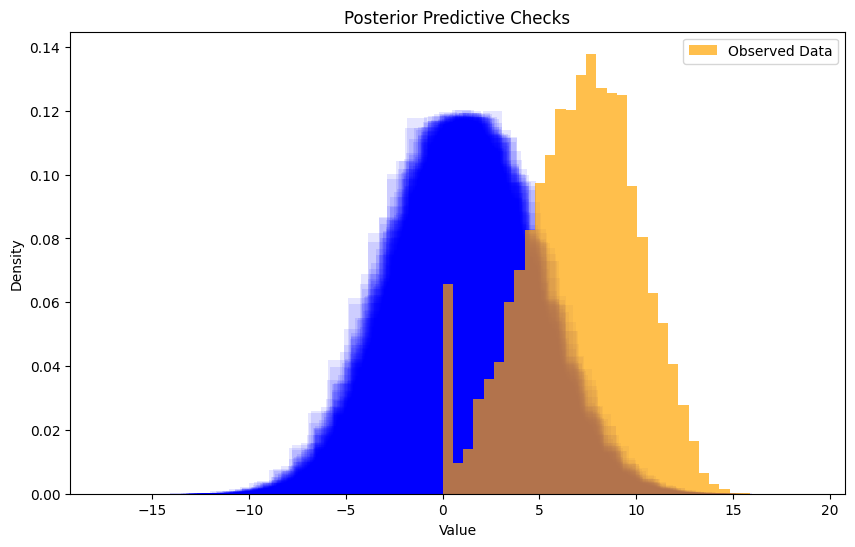

In [6]:
# Define initial values for each chain
def init_values():
    return {
        "mu": np.mean(np.log(df_hierarchical['values_winsorized'].values)),
        "sigma_within": 1.0,
        "sigma_country": 1.0,
        "sigma_industry": 1.0,
        "sigma_indicator": 1.0
    }
# Save initial values as JSON files for each chain
for i in range(4):
    init_file_path = f'init_{i+1}.json'
    with open(init_file_path, 'w') as f:
        json.dump(init_values(), f)

# List of initialization file paths
init_files = [f'init_{i+1}.json' for i in range(4)]

# Run the model
fit = model.sample(
    data=stan_data,
    chains=2,
    parallel_chains=2,
    iter_warmup=500,
    iter_sampling=2000,
    seed=1234,
    inits=[f'init_{i+1}.json' for i in range(4)],  
    adapt_delta=0.99,
    max_treedepth=15,
    show_console=True
)


diagnostic_file_path = r"diagnostics.txt"

# Run diagnostics on the fit object
with open(diagnostic_file_path, "w") as f:
    f.write(fit.diagnose())

# Print the diagnostics
print("Diagnostics saved to:", diagnostic_file_path)

# Display the diagnostics in the console (optional)
diagnostics = fit.diagnose()
print(diagnostics)

# Save results
output_dir = r"C:\Users\stank\Desktop\New folder (2)\cmdstan_output"
shutil.os.makedirs(output_dir, exist_ok=True)

# Copy all CSV output files to the specified directory
for csv_file in fit.runset.csv_files:
    shutil.copy(csv_file, output_dir)

print(f"CmdStan output files are saved to: {output_dir}")

# Save summary statistics to a CSV file
summary_df = fit.summary()
summary_file_path = rf"{output_dir}\model_summary.csv"
summary_df.to_csv(summary_file_path, index=False)
print(f"Summary statistics saved to {summary_file_path}")

# Save all posterior samples to a compressed .npz file
samples_dict = {
    "mu": fit.stan_variable("mu"),
    "sigma_within": fit.stan_variable("sigma_within"),
    "sigma_country": fit.stan_variable("sigma_country"),
    #"sigma_industry": fit.stan_variable("sigma_industry"),
    "u_country": fit.stan_variable("u_country"),
    #"v_industry": fit.stan_variable("v_industry"),
}
posterior_samples_file_path = rf"{output_dir}\posterior_samples.npz"
np.savez_compressed(posterior_samples_file_path, **samples_dict)
print(f"Posterior samples saved to {posterior_samples_file_path}")

# Example: Print the mean of each parameter
print("Mean of mu:", np.mean(samples_dict["mu"]))
print("Mean of sigma_within:", np.mean(samples_dict["sigma_within"]))
print("Mean of sigma_country:", np.mean(samples_dict["sigma_country"]))
#print("Mean of sigma_industry:", np.mean(samples_dict["sigma_industry"]))


import numpy as np
import matplotlib.pyplot as plt

# Load posterior samples from the .npz file
posterior_samples_file_path = r"C:\Users\stank\Desktop\New folder (2)\cmdstan_output\posterior_samples.npz"
posterior_samples = np.load(posterior_samples_file_path)

# Extract posterior samples
mu_samples = posterior_samples["mu"]
sigma_within_samples = posterior_samples["sigma_within"]

# Simulate new data using the posterior predictive distribution
n_simulations = 100  # Number of posterior predictive simulations
n_observations = len(df_hierarchical["values_log"])  # Use values_log from df_hierarchical  # Match the number of observations
posterior_predictive = np.zeros((n_simulations, n_observations))

for i in range(n_simulations):
    # Sample parameters from the posterior
    mu = np.random.choice(mu_samples)
    sigma_within = np.random.choice(sigma_within_samples)

    # Simulate data using the Gaussian likelihood
    posterior_predictive[i, :] = np.random.normal(loc=mu, scale=sigma_within, size=n_observations)

# Load the observed data
observed_data = np.array(df_hierarchical["values_log"])  # Ensure this is a flat array

# Plot posterior predictive checks
plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.hist(
        posterior_predictive[i, :], 
        bins=30, 
        alpha=0.1, 
        color='blue', 
        density=True, 
        label='_nolegend_'  # Prevent legend clutter
    )

# Plot observed data as a histogram
plt.hist(
    observed_data, 
    bins=30, 
    alpha=0.7, 
    color='orange', 
    density=True, 
    label='Observed Data'
)

plt.title("Posterior Predictive Checks")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()



In [ ]:
# Save the diagnostics to a file for review
diagnostic_file_path = r"diagnostics.txt"

# Run diagnostics on the fit object
with open(diagnostic_file_path, "w") as f:
    f.write(fit.diagnose())


# Display the diagnostics in the console (optional)
diagnostics = fit.diagnose()
print(diagnostics)

# Save results
output_dir = r"cmdstan_output"
shutil.os.makedirs(output_dir, exist_ok=True)

for csv_file in fit.runset.csv_files:
    shutil.copy(csv_file, output_dir)

summary_df = fit.summary()
summary_file_path = rf"{output_dir}\model_summary.csv"
summary_df.to_csv(summary_file_path, index=False)

samples_dict = {
    "mu": fit.stan_variable("mu"),
    "sigma_within": fit.stan_variable("sigma_within"),
    "sigma_country": fit.stan_variable("sigma_country"),
    #"sigma_industry": fit.stan_variable("sigma_industry"),
    "u_country": fit.stan_variable("u_country"),
    #"v_industry": fit.stan_variable("v_industry"),
}
posterior_samples_file_path = rf"{output_dir}\posterior_samples.npz"
np.savez_compressed(posterior_samples_file_path, **samples_dict)



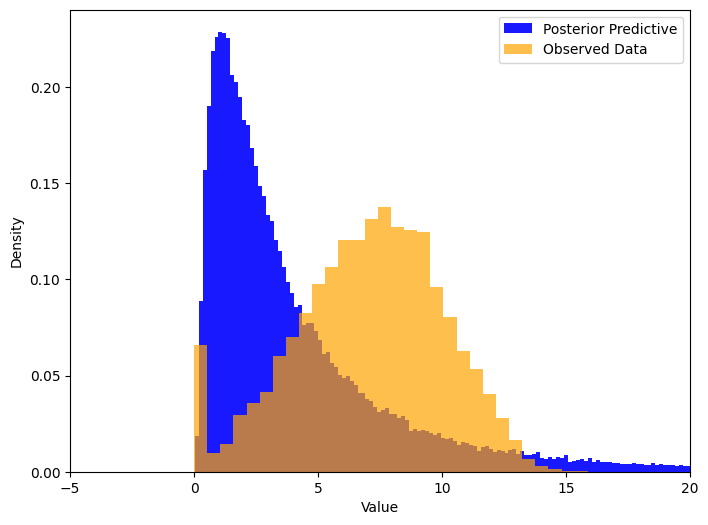

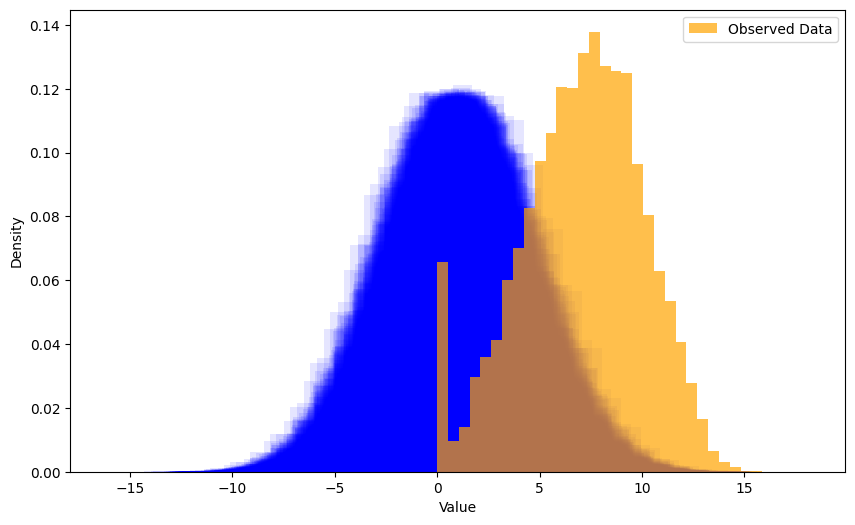

In [16]:

posterior_samples_file_path = r"posterior_samples.npz"
posterior_samples = np.load(posterior_samples_file_path)

#  posterior samples
mu_samples = posterior_samples["mu"]
sigma_within_samples = posterior_samples["sigma_within"]

# Simulate new data using the posterior predictive distribution
n_observations = len(df_hierarchical["values_log"])  
mu = np.mean(mu_samples)  # Use mean of mu
sigma_within = np.clip(np.mean(sigma_within_samples), 0.9, 1.0)  
log_mu = np.log(mu)  
single_simulation = np.random.lognormal(mean=np.mean(mu_samples), sigma=sigma_within, size=n_observations)
observed_data = np.array(df_hierarchical["values_log"])

#  posterior predictive check
plt.figure(figsize=(8, 6))
plt.xlim(-5, 20)
plt.hist(single_simulation, bins=1000, alpha=0.9, color='blue', density=True, label='Posterior Predictive')
plt.hist(observed_data, bins=30, alpha=0.7, color='orange', density=True, label='Observed Data')
#plt.title("Single Posterior Predictive Check")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

n_simulations = 100  
n_observations = len(df_hierarchical["values_log"])  
posterior_predictive = np.zeros((n_simulations, n_observations))

for i in range(n_simulations):

    mu = np.random.choice(mu_samples)
    sigma_within = np.random.choice(sigma_within_samples)

    posterior_predictive[i, :] = np.random.normal(loc=mu, scale=sigma_within, size=n_observations)

#  posterior predictive checks
plt.figure(figsize=(10, 6))
for i in range(n_simulations):
    plt.hist(
        posterior_predictive[i, :], 
        bins=30, 
        alpha=0.1, 
        color='blue', 
        density=True, 
        label='_nolegend_'  
    )

plt.hist(
    observed_data, 
    bins=30, 
    alpha=0.7, 
    color='orange', 
    density=True, 
    label='Observed Data'
)

#plt.title("Posterior Predictive Checks")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()




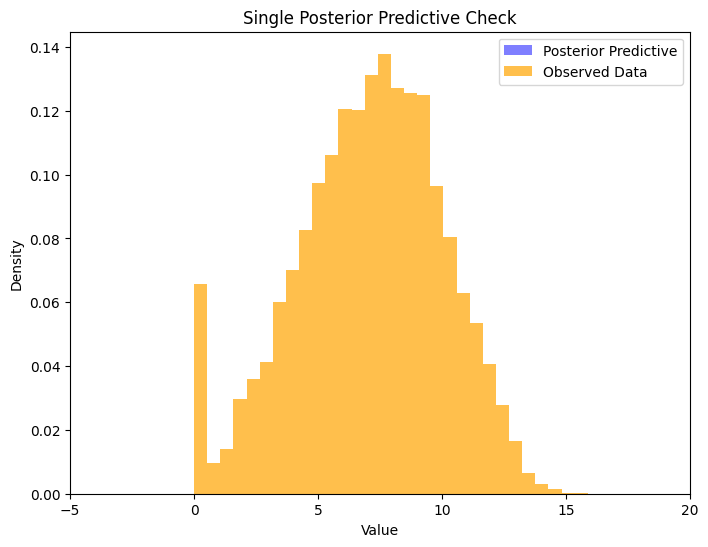

In [64]:
import numpy as np
import matplotlib.pyplot as plt

single_simulation = np.random.lognormal(
    mean=np.log(np.mean(mu_samples)),  
    sigma=np.mean(sigma_within_samples),  
    size=n_observations
)


#  posterior predictive check
plt.figure(figsize=(8, 6))
plt.xlim(-5, 20)
plt.hist(single_simulation, bins=30, alpha=0.5, color='blue', density=True, label='Posterior Predictive')
plt.hist(observed_data, bins=30, alpha=0.7, color='orange', density=True, label='Observed Data')
plt.title("Single Posterior Predictive Check")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


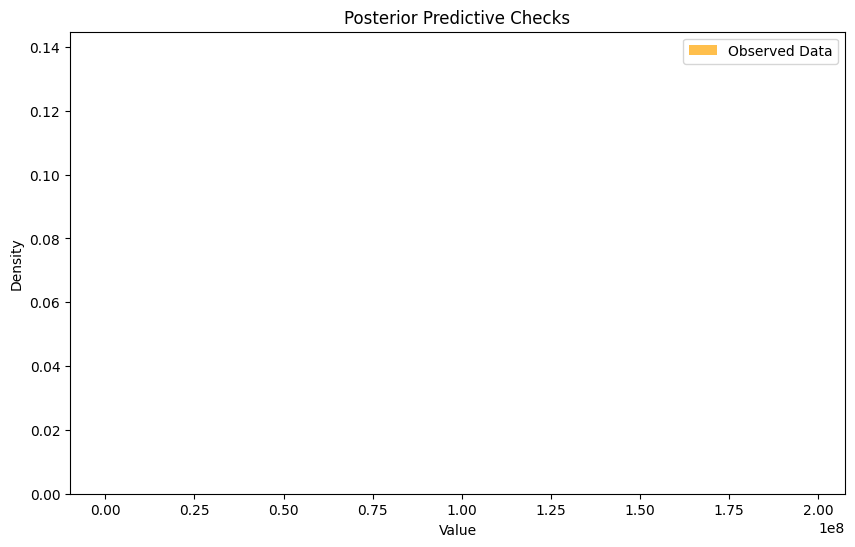

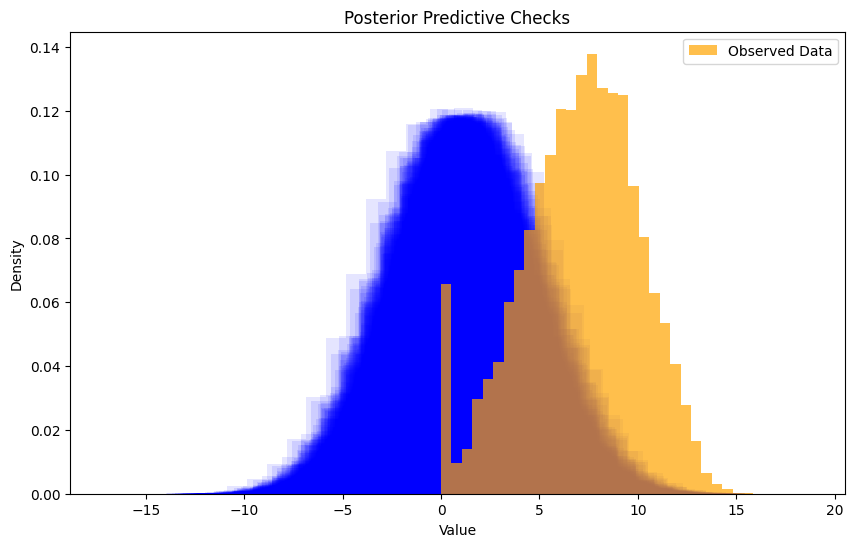

In [9]:

summary_df = pd.read_csv(r"Cmodel_summary.csv")

print(summary_df.head())

print(summary_df.info())





            Mean      MCSE    StdDev       MAD             5%            50%  \
0 -254548.000000  0.197193  7.446280  7.413000 -254561.000000 -254548.000000   
1       1.052100  0.204253  0.573416  0.535345       0.165361       1.035730   
2       3.365330  0.000097  0.007673  0.007598       3.352610       3.365330   
3       0.434184  0.019122  0.393806  0.364411      -0.206328       0.445983   
4       0.416441  0.019165  0.394505  0.361548      -0.224804       0.423169   

            95%  ESS_bulk  ESS_tail    R_hat  
0 -254536.00000  1421.230  2186.770  1.00073  
1       1.96299    14.198   216.028  1.10961  
2       3.37787  6300.460  2568.830  1.00027  
3       1.07163   441.997   505.620  1.00689  
4       1.05222   444.363   522.259  1.00653  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96744 entries, 0 to 96743
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Mean      96744 non-null  float64
 1   MCSE  

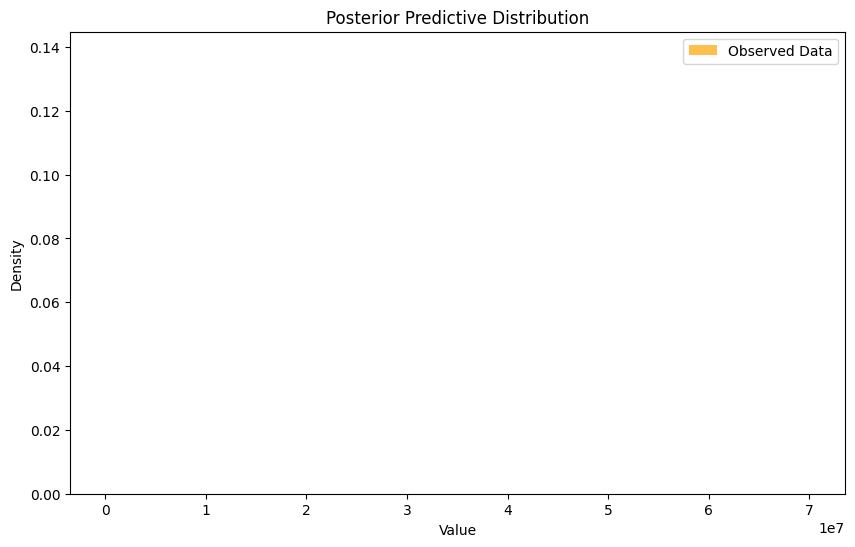

In [21]:
plt.figure(figsize=(10, 6))
for i in range(20): 
    plt.hist(posterior_predictive[i, :], bins=30, alpha=0.1, color='blue', density=True, label='_nolegend_')

plt.hist(observed[:len(posterior_means)], bins=30, alpha=0.7, color='orange', density=True, label='Observed Data')
plt.title("Posterior Predictive Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()



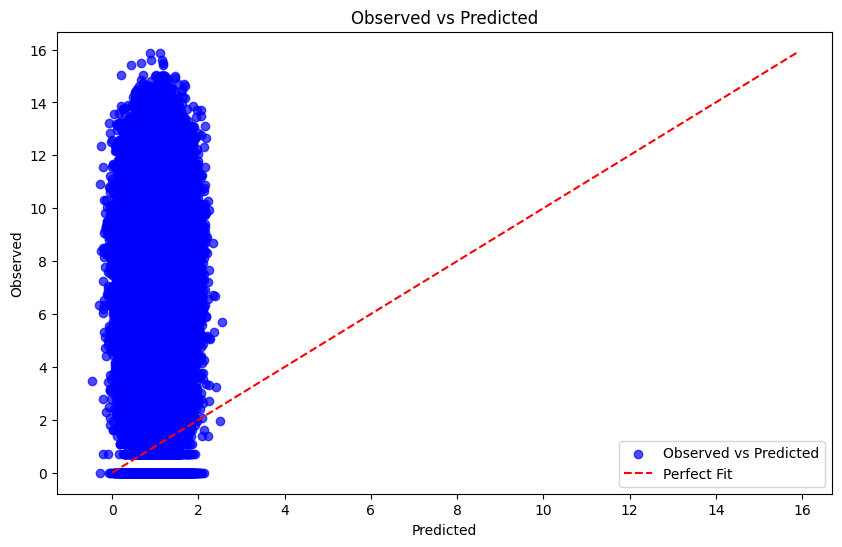

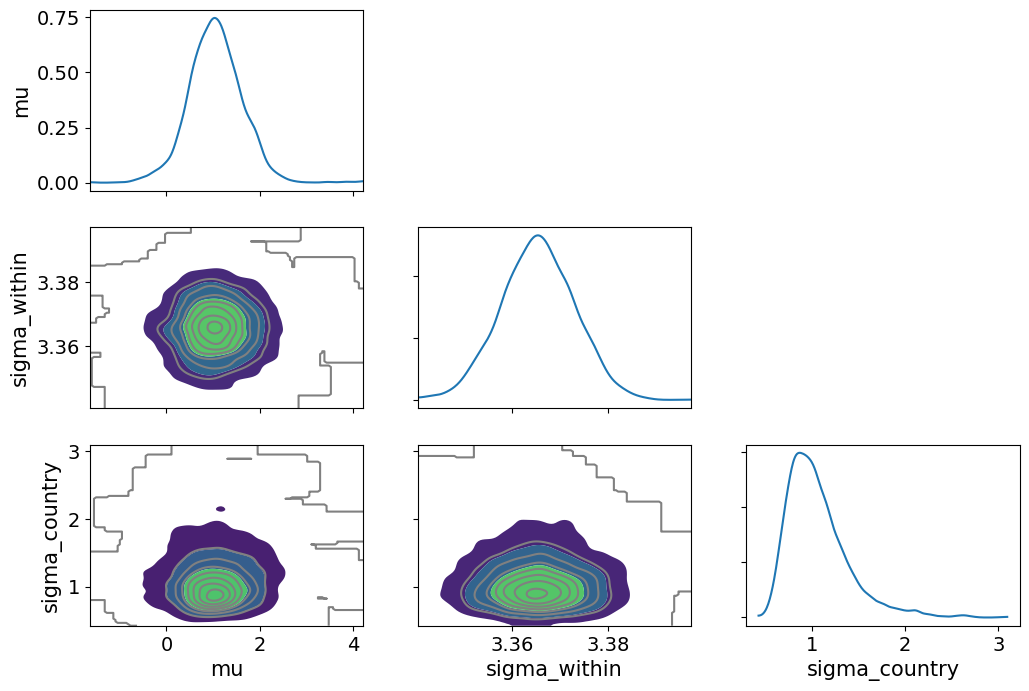

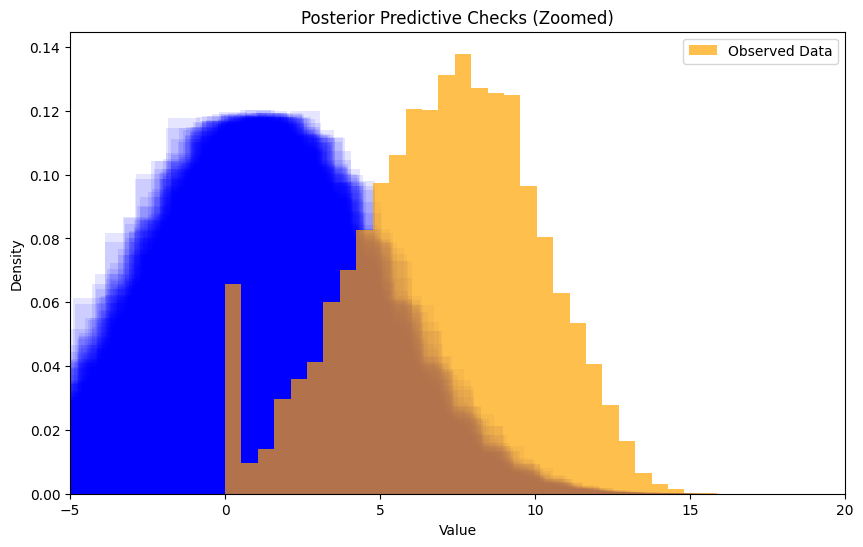

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(posterior_means, observed[:len(posterior_means)], alpha=0.7, color="blue", label="Observed vs Predicted")
plt.plot([observed.min(), observed.max()], [observed.min(), observed.max()], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Observed vs Predicted")
plt.legend()
plt.show()

# Pairwise posterior plot for parameters (mu, sigma_within, sigma_country)
posterior_samples = {
    "mu": posterior_samples["mu"],
    "sigma_within": posterior_samples["sigma_within"],
    "sigma_country": posterior_samples["sigma_country"]
}

idata_subset = az.from_dict(posterior=posterior_samples)

# Pairplot
az.plot_pair(idata_subset, kind="kde", marginals=True, figsize=(12, 8))
plt.show()

plt.figure(figsize=(10, 6))

for i in range(n_simulations):
    plt.hist(posterior_predictive[i, :], bins=30, alpha=0.1, color='blue', density=True, label='_nolegend_')

plt.hist(observed[:len(posterior_means)], bins=30, alpha=0.7, color='orange', density=True, label='Observed Data')
plt.xlim(-5, 20) 
plt.title("Posterior Predictive Checks (Zoomed)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()



NameError: name 'sigma_country_samples' is not defined

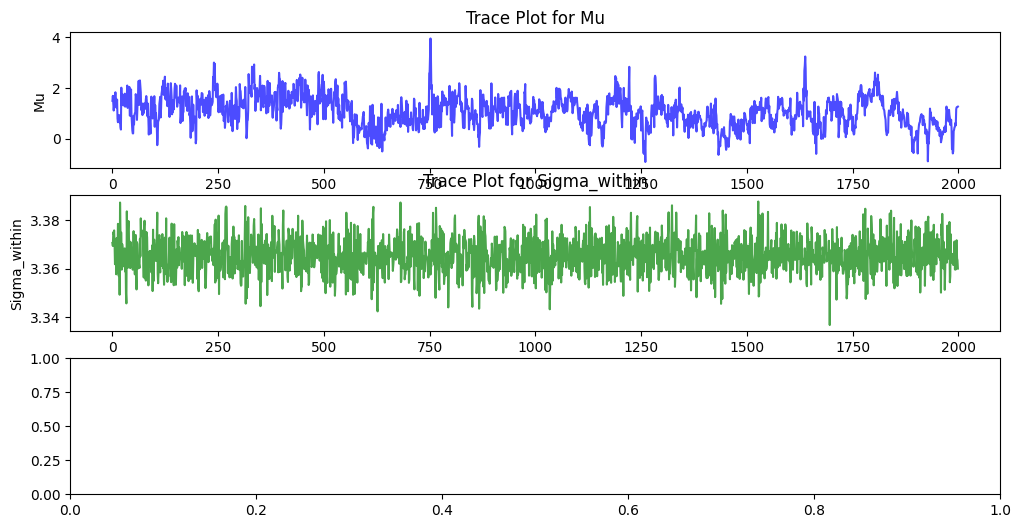

In [74]:
plt.figure(figsize=(12, 6))

# Trace plot for `mu`
plt.subplot(3, 1, 1)
plt.plot(mu_samples, color="blue", alpha=0.7)
plt.title("Trace Plot for Mu")
plt.xlabel("Iteration")
plt.ylabel("Mu")

# Trace plot for `sigma_within`
plt.subplot(3, 1, 2)
plt.plot(sigma_within_samples, color="green", alpha=0.7)
plt.title("Trace Plot for Sigma_within")
plt.xlabel("Iteration")
plt.ylabel("Sigma_within")

# Trace plot for `sigma_country`
plt.subplot(3, 1, 3)
plt.plot(sigma_country_samples, color="red", alpha=0.7)
plt.title("Trace Plot for Sigma_country")
plt.xlabel("Iteration")
plt.ylabel("Sigma_country")

plt.tight_layout()
plt.show()


In [ ]:

# Calculate residuals
observed = np.array(df_hierarchical["values_log"]) 
posterior_means = np.mean(posterior_predictive, axis=0)  # Mean of posterior predictions
residuals = observed[:len(posterior_means)] - posterior_means  # Ensure dimensions align

# Plot residual histogram
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Observed - Predicted)")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot for residuals
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()



In [ ]:
model = CmdStanModel(stan_file=stan_model_path)
stan_model_path = r"C:\Users\stank\Desktop\New folder (2)\hierarchical_model.stan"

# Define k-fold cross-validation
N = len(df_hierarchical)
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Model path
model = CmdStanModel(stan_file=stan_model_path)

# Cross-validation results storage
cv_results = []

for fold, (train_idx, test_idx) in enumerate(kf.split(df_hierarchical)):
    print(f"Processing Fold {fold + 1}...")
    
    # Split the data
    train_data = df_hierarchical.iloc[train_idx]
    test_data = df_hierarchical.iloc[test_idx]
    
    #  Stan data
    stan_data = {
        "N": len(train_data),
        "J": len(train_data["CountryCode"].unique()),
        "K": len(train_data["Industry"].unique()),
        "L": len(train_data["Indicator"].unique()),
        "country": train_data["CountryCode"].factorize()[0] + 1,
        "industry": train_data["Industry"].factorize()[0] + 1,
        "indicator": train_data["Indicator"].factorize()[0] + 1,
        "log_size": train_data["values_winsorized"].values,
    }
    
    #  model
    fit = model.sample(data=stan_data, chains=2, parallel_chains=2, iter_sampling=1000, iter_warmup=500)
    
    #  predictions for test set
    posterior_samples = fit.draws_pd()
    mu_samples = posterior_samples["mu"].values
    sigma_within_samples = posterior_samples["sigma_within"].values
    
    #  posterior predictive samples for test set
    test_predictions = []
    for mu, sigma in zip(mu_samples, sigma_within_samples):
        pred = np.random.lognormal(mean=mu, sigma=sigma, size=len(test_data))
        test_predictions.append(pred)
    
    #  metrics
    test_predictions_mean = np.mean(test_predictions, axis=0)
    rmse = np.sqrt(np.mean((test_data["values_winsorized"] - test_predictions_mean) ** 2))
    mae = np.mean(np.abs(test_data["values_winsorized"] - test_predictions_mean))
    

    cv_results.append({"Fold": fold + 1, "RMSE": rmse, "MAE": mae})

# Cross-validation summary
cv_results_df = pd.DataFrame(cv_results)
print("\nCross-Validation Results:")
print(cv_results_df)

#  RMSE across folds
plt.figure(figsize=(8, 6))
plt.bar(cv_results_df["Fold"], cv_results_df["RMSE"], color="skyblue")
plt.title("Cross-Validation RMSE")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.show()

# Robustness Checks: Posterior Predictive Checks
def posterior_predictive_checks(fit, observed_data):
    mu_samples = fit.stan_variable("mu")
    sigma_within_samples = fit.stan_variable("sigma_within")
    posterior_predictive = np.random.lognormal(
        mean=mu_samples.mean(), sigma=sigma_within_samples.mean(), size=len(observed_data)
    )
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(posterior_predictive, bins=30, alpha=0.7, label="Posterior Predictive", color="blue", density=True)
    plt.hist(observed_data, bins=30, alpha=0.7, label="Observed Data", color="orange", density=True)
    plt.title("Posterior Predictive Checks")
    plt.legend()
    plt.show()

posterior_predictive_checks(fit, df_hierarchical["values_winsorized"].values)

print(fit.summary())
az.plot_posterior(fit, var_names=['mu', 'sigma_within', 'u_country', 'v_industry', 'w_indicator'])